In [12]:
!pip install pandas

In [4]:
!pip install seaborn

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)


In [8]:
!pip install numpy

In [ ]:
!pip install matplotlib

In [10]:
!pip install scikit-learn

In [93]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter


data = pd.read_csv("BankChurners.csv")
data = data.drop(["CLIENTNUM"], axis=1)
# data["Attrition_Flag"] = data["Attrition_Flag"].map({"Attrited Customer": 0,
#                                                      "Existing Customer": 1})


In [24]:
data

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,Graduate,Single,$40K - $60K,Blue,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,Unknown,Divorced,$40K - $60K,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,High School,Married,Less than $40K,Blue,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,4,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [14]:
def get_unique(x: np.ndarray, y: np.ndarray):
    x_set = np.array([x[0, :], ])
    y_set = np.array([y[0]])
    for i in range(len(x)):
        for j in range(len(x_set)):
            if all(x_set[j, :] == x[i, :]):
                break
        else:
            x_set = np.vstack((x_set, x[i, :]))
            y_set = np.vstack((y_set, y[i]))
    return x_set, y_set

def analyze_data(dataset: pd.core.frame.DataFrame, target_name: str,
                 max_diff: float):
    target_data_arr = dataset[target_name].values
    dataset = dataset.drop([target_name], axis=1)
    trash_features = []
    for feature_name in dataset.keys():
        feature_data = dataset[feature_name]
        feature_data_dict = dict() # feature_data_dict =
        # {<feature_i-data>:  {
        #                     "count": <numb of same feature_i-data>,
        #                     "pos_target": <numb of positive target for objects with this feature_i-data>,
        #                     "neg_target": <numb of negative target for objects with this feature_i-data>
        #                     }
        # }

        for idx, feat_i in enumerate(feature_data):
            if feature_data_dict.get(feat_i, None) is None:
                feature_data_dict[feat_i] = {"count": 1, "pos_target": 0, "neg_target": 0}
            else:
                feature_data_dict[feat_i]["count"] += 1

            if target_data_arr[idx] == 0:
                feature_data_dict[feat_i]["neg_target"] += 1
            else:
                feature_data_dict[feat_i]["pos_target"] += 1

        print(f"\n{feature_name} pos/neg target ratio:")
        feature_i_ratio = []
        for i in feature_data_dict.items():
            pos = i[1]['pos_target'] # number of positive target for objects with this feature_i-data
            neg = i[1]['neg_target'] # number of negative target for objects with this feature_i-data
            if (neg == 0 or pos == 0):
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg}"
            else:
                info_str = f"{feature_name} : {i[0]} ,ratio = {pos} / {neg} = {round(pos / neg, 3)} " \
                           f"\tpos_perc = {round(100 * pos / (pos + neg), 2)}%, " \
                           f"neg_perc = {round(100 * neg / (pos + neg), 2)}%"
                feature_i_ratio.append(pos / neg)
            print(info_str)
        if (max(feature_i_ratio) - min(feature_i_ratio) < max_diff):
            trash_features.append(feature_name)
    return trash_features

def identify_data_type(dataset: pd.core.frame.DataFrame):
    features_list = list(dataset.columns)
    features_types_dict = {"Categorical": [], "Numerical": []}
    for feature_name in features_list:
        if any([type_i in data[feature_name].dtype.name
                for type_i in ["int", "object"]]):
            features_types_dict["Categorical"].append(feature_name)
        elif "float" in data[feature_name].dtype.name:
            features_types_dict["Numerical"].append(feature_name)
    return features_types_dict

def get_metrics(targets: np.ndarray, predicted_targets: np.ndarray, mode: str):
    '''

    :param targets:
    :param predicted_targets:
    :param mode: influence to return: mode = "show_metrics" - print metrics to the Console;
                                        mode = "return_metrics" - return dict which consists all metrics values
                                        with their names as keys
    :return:
    {
    "accuracy": accuracy_value, "precision": precision_value,
    "recall": recall_value, "f1_score": f1_score_value,
    "confusion_matrix": confusion_matrix
    }
    '''
    # token = (actual target, predicted target)
    # 1 - positive target, 0 - negative target
    tokens = [(j, i) for i in [1, 0] for j in [1, 0]]
    # tokens = [true_pos_token,
    #           false_pos_token,
    #           false_neg_token,
    #           false_pos_token]
    c = Counter(zip(targets, predicted_targets))
    [true_pos_value,
     false_pos_value,
     false_neg_value,
     true_neg_value] = [c[token] for token in tokens]
    # print(f"true positive value = {true_pos_value}")
    # print(f"false positive value = {false_pos_value}")
    # print(f"false negative value = {false_neg_value}")
    # print(f"true negative value = {true_neg_value}")
    accuracy = (true_neg_value + true_neg_value) / len(targets)
    precision = true_pos_value / (true_pos_value + false_pos_value)
    recall = true_pos_value / (true_pos_value + false_neg_value)
    f1_score = 2 * precision * recall / (precision + recall)
    confusion_matrix = np.array([[true_pos_value, false_neg_value],
                                 [false_pos_value, true_neg_value]])
    if mode == "show_metrics":
        print(f"accuracy = {accuracy}")
        print(f"precision = {precision}")
        print(f"recall = {recall}")
        print(f"f1_score = {f1_score}")
        print(f"confusion_matrix = \n{confusion_matrix}")
    elif mode == "return_metrics":
        res_dict = {"accuracy": accuracy, "precision": precision, "recall": recall,
                    "f1_score": f1_score, "confusion_matrix": confusion_matrix}
        return res_dict




accuracy = 0.25
precision = 0.75
recall = 0.5
f1_score = 0.6
confusion_matrix = 
[[3 3]
 [1 1]]


# dataset preparing

In [ ]:
get_metrics(targets=np.array([1,1,1,0,1,0,1,1]),
            predicted_targets=np.array([1,1,0,1,0,0,1,0]),
            mode="show_metrics")

In [31]:
drop_features = [
    "Credit_Limit", "Total_Revolving_Bal",
    "Avg_Open_To_Buy", "Total_Amt_Chng_Q4_Q1",
    "Total_Ct_Chng_Q4_Q1", "Total_Trans_Amt",
    "Avg_Utilization_Ratio",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2"
]

Le = LabelEncoder()
data["Attrition_Flag"] = Le.fit_transform(data["Attrition_Flag"].values)

analyze_data(dataset=data.drop(drop_features, axis=1), target_name="Attrition_Flag",
             max_diff=1.5)


Customer_Age pos/neg target ratio:
Customer_Age : 45 ,ratio = 407 / 79 = 5.152 	pos_perc = 83.74%, neg_perc = 16.26%
Customer_Age : 49 ,ratio = 416 / 79 = 5.266 	pos_perc = 84.04%, neg_perc = 15.96%
Customer_Age : 51 ,ratio = 340 / 58 = 5.862 	pos_perc = 85.43%, neg_perc = 14.57%
Customer_Age : 40 ,ratio = 297 / 64 = 4.641 	pos_perc = 82.27%, neg_perc = 17.73%
Customer_Age : 44 ,ratio = 416 / 84 = 4.952 	pos_perc = 83.2%, neg_perc = 16.8%
Customer_Age : 32 ,ratio = 89 / 17 = 5.235 	pos_perc = 83.96%, neg_perc = 16.04%
Customer_Age : 37 ,ratio = 223 / 37 = 6.027 	pos_perc = 85.77%, neg_perc = 14.23%
Customer_Age : 48 ,ratio = 387 / 85 = 4.553 	pos_perc = 81.99%, neg_perc = 18.01%
Customer_Age : 42 ,ratio = 364 / 62 = 5.871 	pos_perc = 85.45%, neg_perc = 14.55%
Customer_Age : 65 ,ratio = 92 / 9 = 10.222 	pos_perc = 91.09%, neg_perc = 8.91%
Customer_Age : 56 ,ratio = 219 / 43 = 5.093 	pos_perc = 83.59%, neg_perc = 16.41%
Customer_Age : 35 ,ratio = 163 / 21 = 7.762 	pos_perc = 88.59%, neg

['Gender', 'Dependent_count', 'Marital_Status']

# data type identifying

In [17]:
features_types = identify_data_type(dataset=data)
numerical_features = features_types["Numerical"]
ordinal_features = ["Customer_Age", "Dependent_count", "Education_Level",
                "Income_Category", "Months_on_book", "Total_Relationship_Count",
                "Months_Inactive_12_mon", "Contacts_Count_12_mon", "Total_Revolving_Bal",
                    "Total_Trans_Amt", "Total_Trans_Ct"]
categorical_features = [i for i in features_types["Categorical"] if i not in ordinal_features]
# data[features_types["Categorical"]]
categorical_features

['Attrition_Flag', 'Gender', 'Marital_Status', 'Card_Category']

In [159]:
Counter(data[categorical_features]["Total_Revolving_Bal"])

Counter({777: 4,
         864: 6,
         0: 2470,
         2517: 508,
         1247: 7,
         2264: 5,
         1396: 9,
         1677: 4,
         1467: 2,
         1587: 6,
         1666: 5,
         680: 6,
         972: 5,
         2362: 3,
         1291: 8,
         1157: 5,
         1800: 5,
         1560: 10,
         1669: 5,
         1374: 3,
         1010: 9,
         1362: 6,
         1811: 5,
         1690: 4,
         1490: 6,
         1696: 9,
         1914: 2,
         2298: 1,
         886: 4,
         605: 2,
         578: 3,
         2204: 2,
         2055: 7,
         1430: 9,
         2020: 2,
         1435: 8,
         1227: 4,
         1549: 8,
         808: 6,
         2179: 3,
         2200: 4,
         2363: 1,
         1880: 7,
         978: 6,
         1753: 5,
         2016: 6,
         1251: 9,
         2102: 2,
         1634: 5,
         1515: 7,
         1817: 8,
         1468: 7,
         1107: 4,
         1330: 2,
         1763: 4,
         1034: 4

In [189]:
data1 = data[ordinal_features[2: 4]]
list(zip(Le.fit_transform(data1["Education_Level"].values), data1["Education_Level"].values))
data1["Education_Level"].unique()

array(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'], dtype=object)

# feature visualizing

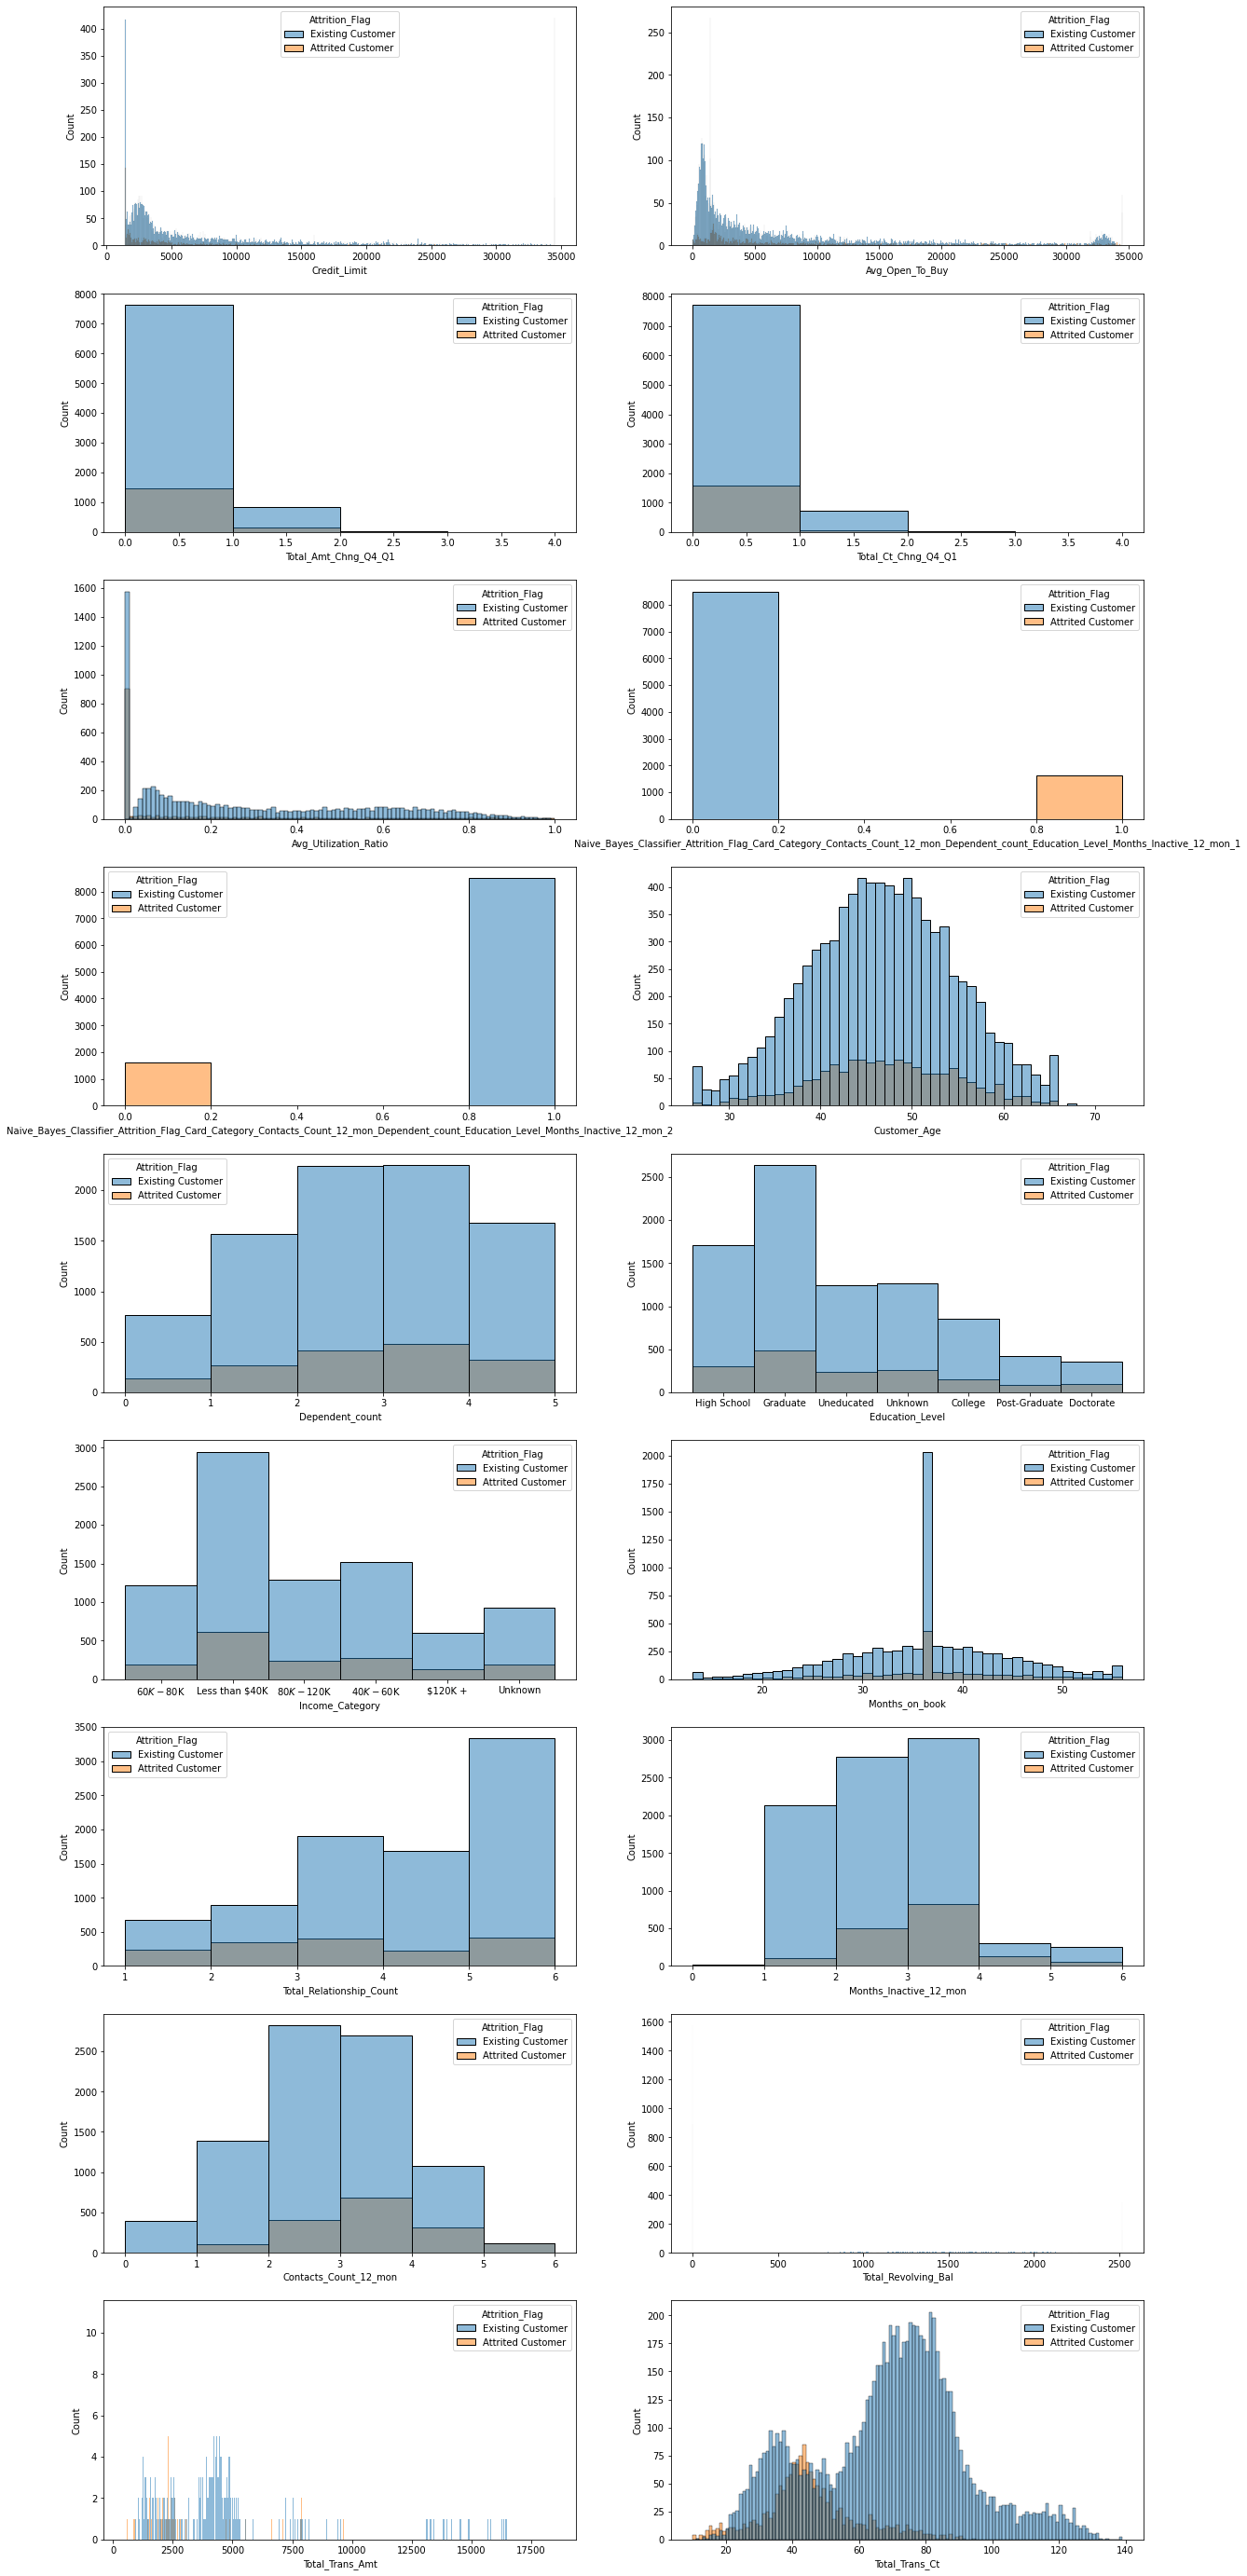

In [18]:
user_binwidth = 40
plt.figure(figsize=((20, 50)))
figures_numb_in_row = 2
hist_vizual_data = data[[*numerical_features,
                         *ordinal_features]]
for idx, feature in enumerate(hist_vizual_data):
    if(idx < 21):
        if (feature in numerical_features[-2:]):
            user_binwidth = 0.2
        if (feature in numerical_features[:2]):
            user_binwidth = 40
        if feature in categorical_features[-3: -1]:
            user_binwidth = 100
        if feature == "Avg_Utilization_Ratio":
            user_binwidth = 0.01
        plt.subplot(hist_vizual_data.shape[1] // figures_numb_in_row + (0 if(hist_vizual_data.shape[1] % figures_numb_in_row == 0) else 1),
                    figures_numb_in_row, idx + 1)
        sns.histplot(x=feature,
                     data=data[[feature, "Attrition_Flag"] if feature != "Attrition_Flag" else [feature]],
                     color=["blue", "green"], hue="Attrition_Flag", binwidth=user_binwidth)
        user_binwidth = 1


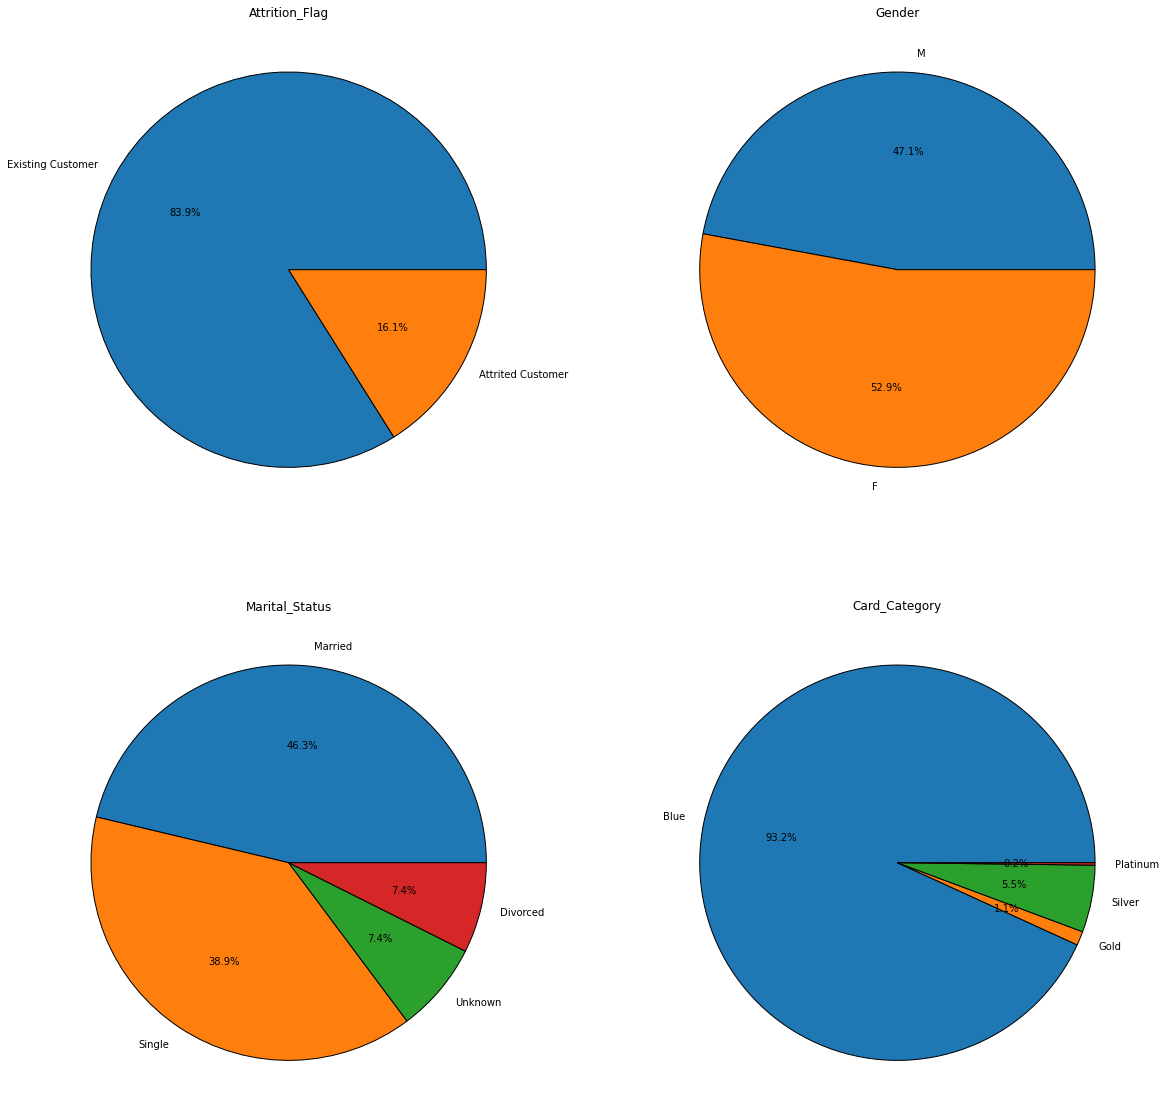

In [19]:
plt.figure(figsize=((20, 20)))
figures_numb_in_row = 2
pie_vizual_data = data[categorical_features]
for idx, feature in enumerate(pie_vizual_data):
    if 1:
        plt.subplot(pie_vizual_data.shape[1] // figures_numb_in_row + (0 if(pie_vizual_data.shape[1] % figures_numb_in_row == 0) else 1),
                    figures_numb_in_row, idx + 1)
        c = Counter(pie_vizual_data[feature])
        plt.title(feature)
        plt.pie(c.values(), labels=c.keys(), wedgeprops={"edgecolor": "black"}, autopct='%1.1f%%')

,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0.000093,0.999910
1,0.000057,0.999940
2,0.000021,0.999980
3,0.000134,0.999870
4,0.000022,0.999980
...,...,...
10122,0.000191,0.999810
10123,0.995270,0.004729
10124,0.997880,0.002118
10125,0.996710,0.003294


<AxesSubplot:xlabel='Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', ylabel='Count'>

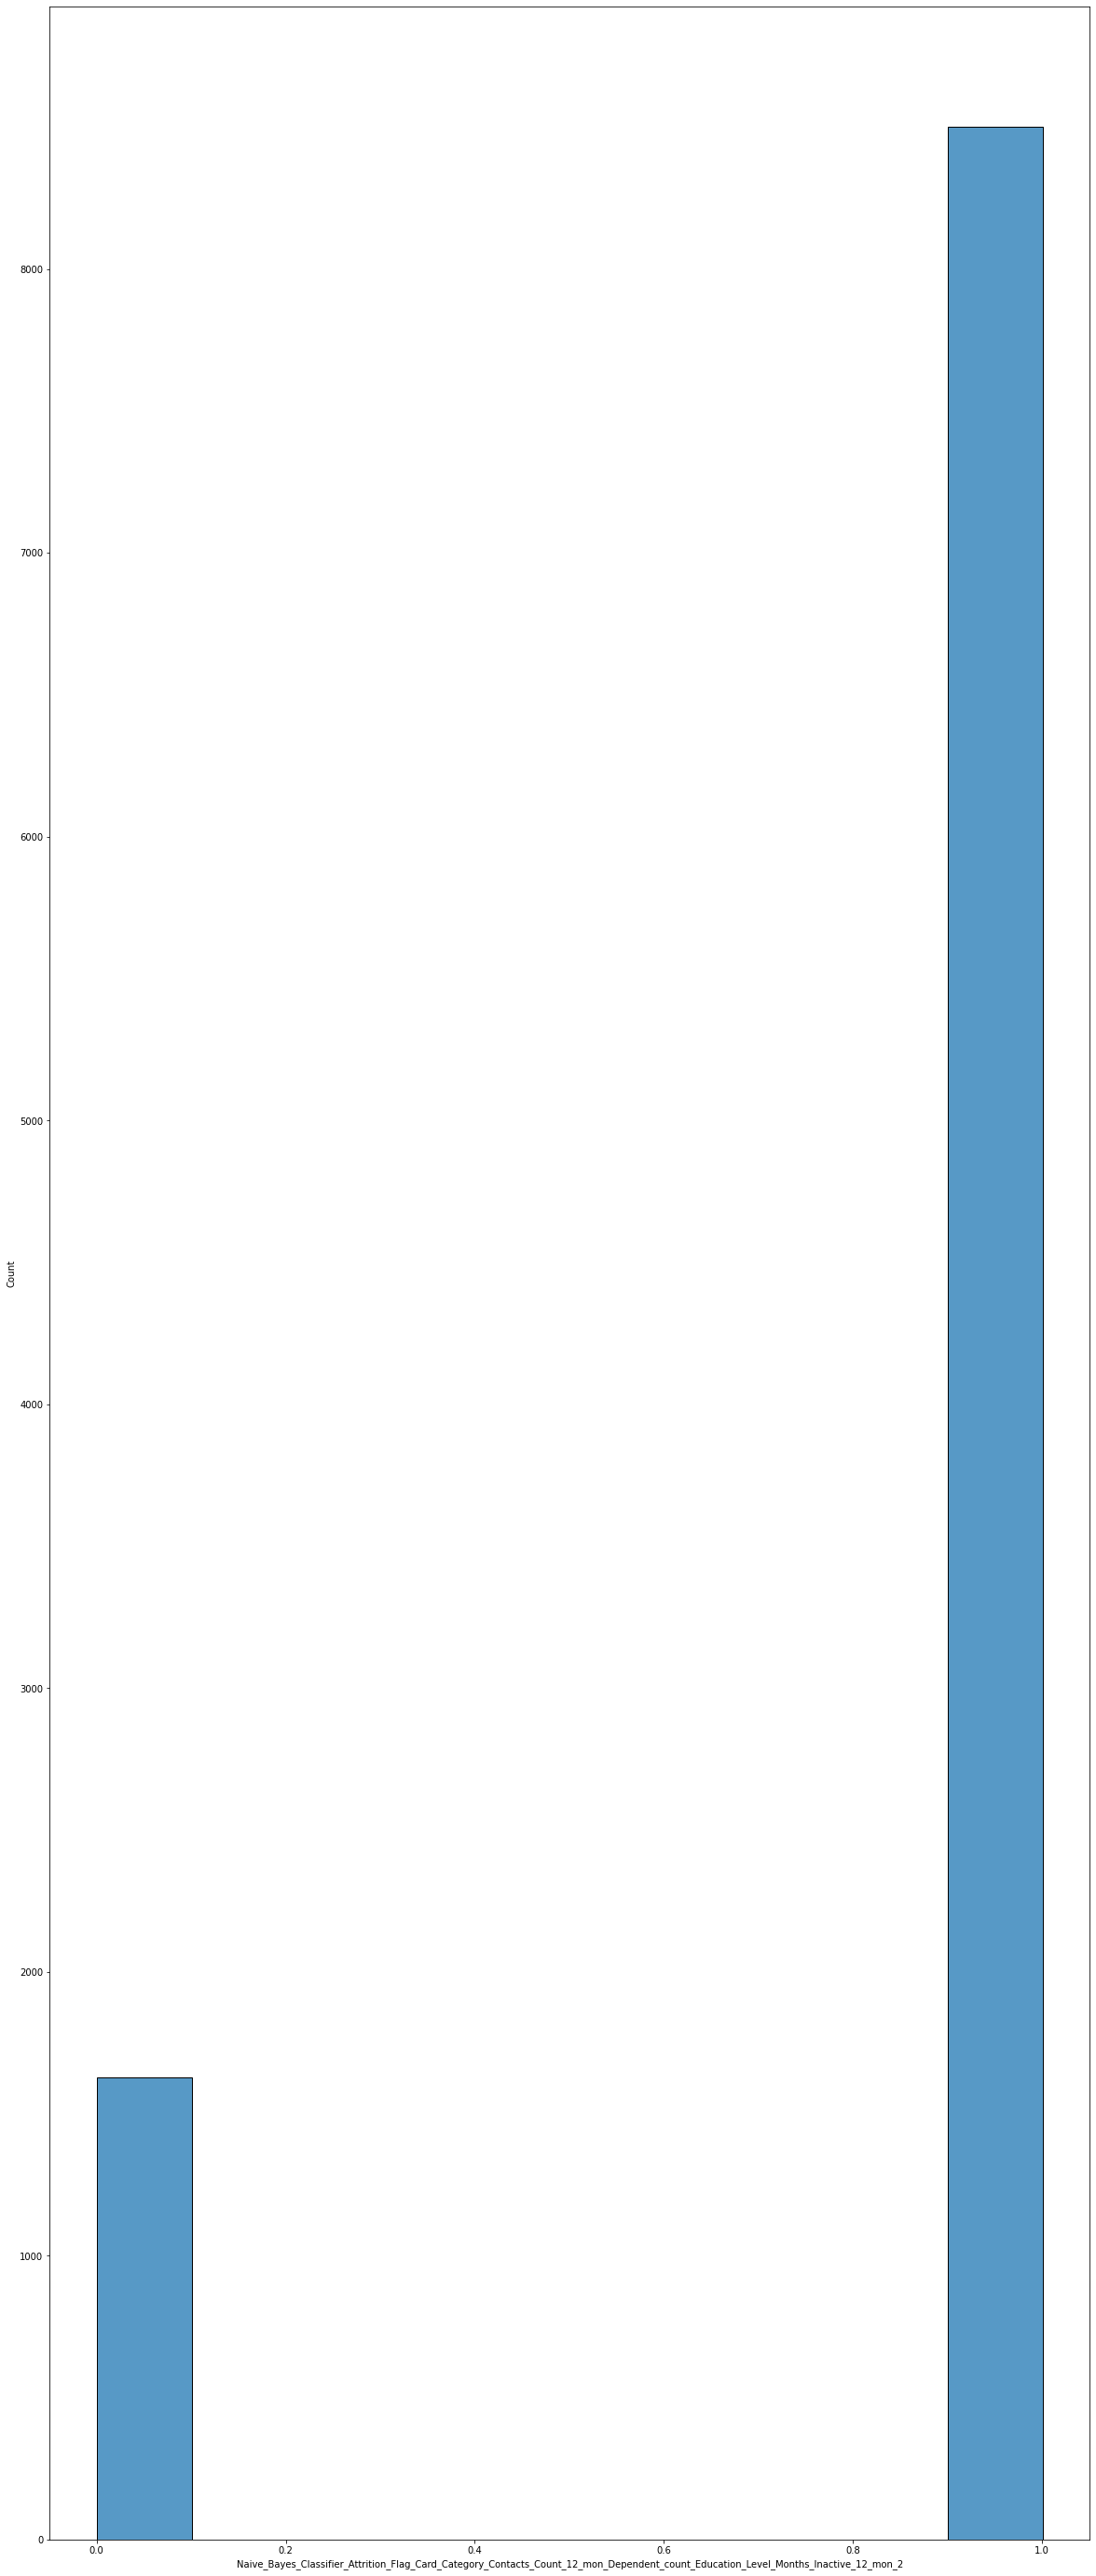

In [199]:
plt.figure(figsize=((20, 50)))
plt.subplot(1, 1, 1)
sns.histplot(data=data[numerical_features[-2:]], x=numerical_features[-1], binwidth=0.1, )

([<matplotlib.patches.Wedge at 0x149948d4940>,
 [Text(0.10035590564411727, 1.0954125671190509, 'M'),
  Text(-0.10035590564411717, -1.0954125671190509, 'F')])

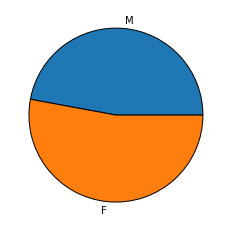

# feature's statistic

In [94]:
data1 = data
education_level_map = {"Unknown": 0,"Uneducated": 1, "High School": 2, "College": 3, "Graduate": 4,
                       "Post-Graduate": 5, "Doctorate": 6}
income_category_map = {'$60K - $80K': 3, 'Less than $40K': 1, '$80K - $120K': 4, '$40K - $60K': 2,
                       '$120K +': 5, 'Unknown': 0}
# education level encoding
data1["Education_Level"] = data1["Education_Level"].map(education_level_map)
# income category encoding
data1["Income_Category"] = data1["Income_Category"].map(income_category_map)

mean value of Customer_Age = 46.32596030413745
mean value of Dependent_count = 2.3462032191172115
mean value of Education_Level = 2.601955169349264
mean value of Income_Category = 2.0857114644020935
mean value of Months_on_book = 35.928409203120374
mean value of Total_Relationship_Count = 3.8125802310654686
mean value of Months_Inactive_12_mon = 2.3411671768539546
mean value of Contacts_Count_12_mon = 2.4553174681544387
mean value of Total_Revolving_Bal = 1162.8140614199665
mean value of Total_Trans_Amt = 4404.086303939963
mean value of Total_Trans_Ct = 64.85869457884863
mean value of Credit_Limit = 8631.953698034955
mean value of Avg_Open_To_Buy = 7469.139636614989
mean value of Total_Amt_Chng_Q4_Q1 = 0.759940653698035
mean value of Total_Ct_Chng_Q4_Q1 = 0.7122223758269972
mean value of Avg_Utilization_Ratio = 0.2748935518909845
mean value of Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 = 0.159997463

# mean, standard_deviation

In [98]:
for stat_i in ["mean", "standard_deviation"]:
    for feature in data1[[*ordinal_features, *numerical_features]]:
        if stat_i == 'mean':
            print(f"mean value of {feature} = {data1[feature].mean()}")
        elif stat_i == "standard_deviation":
            print(f"standard_deviation value of {feature} = {data1[feature].std()}")

mean value of Customer_Age = 46.32596030413745
mean value of Dependent_count = 2.3462032191172115
mean value of Education_Level = 2.601955169349264
mean value of Income_Category = 2.0857114644020935
mean value of Months_on_book = 35.928409203120374
mean value of Total_Relationship_Count = 3.8125802310654686
mean value of Months_Inactive_12_mon = 2.3411671768539546
mean value of Contacts_Count_12_mon = 2.4553174681544387
mean value of Total_Revolving_Bal = 1162.8140614199665
mean value of Total_Trans_Amt = 4404.086303939963
mean value of Total_Trans_Ct = 64.85869457884863
mean value of Credit_Limit = 8631.953698034955
mean value of Avg_Open_To_Buy = 7469.139636614989
mean value of Total_Amt_Chng_Q4_Q1 = 0.759940653698035
mean value of Total_Ct_Chng_Q4_Q1 = 0.7122223758269972
mean value of Avg_Utilization_Ratio = 0.2748935518909845
mean value of Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1 = 0.159997463

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,Existing Customer,45,M,3,2,Married,3,Blue,39,5,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,Existing Customer,49,F,5,4,Single,1,Blue,44,6,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,Existing Customer,51,M,3,4,Married,4,Blue,36,4,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,Existing Customer,40,F,4,2,Unknown,1,Blue,34,3,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,Existing Customer,40,M,3,1,Married,3,Blue,21,5,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,Existing Customer,50,M,2,4,Single,2,Blue,40,3,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,Attrited Customer,41,M,2,0,Divorced,2,Blue,25,4,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,Attrited Customer,44,F,1,2,Married,1,Blue,36,5,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,Attrited Customer,30,M,2,4,Unknown,2,Blue,36,4,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


# correlation matrix

In [100]:
data1[[*ordinal_features, *numerical_features]].corr()


,Customer_Age,Dependent_count,Education_Level,Income_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Trans_Amt,Total_Trans_Ct,Credit_Limit,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
Customer_Age,1.000000,-0.122254,-0.002369,0.023508,0.788912,-0.010931,0.054361,-0.018452,0.014780,-0.046446,-0.067097,0.002476,0.001151,-0.062042,-0.012143,0.007114,0.018189,-0.018189
Dependent_count,-0.122254,1.000000,0.000472,0.066278,-0.103062,-0.039076,-0.010768,-0.040505,-0.002688,0.025046,0.049912,0.068065,0.068291,-0.035439,0.011087,-0.037135,0.019189,-0.019189
Education_Level,-0.002369,0.000472,1.000000,-0.011677,0.006613,0.000766,0.005761,-0.006280,-0.006800,-0.007460,-0.004307,-0.002354,-0.001743,-0.010040,-0.016692,-0.001849,0.008890,-0.008890
Income_Category,0.023508,0.066278,-0.011677,1.000000,0.022122,-0.003202,-0.016310,0.023113,0.034718,0.019651,-0.054569,0.475972,0.472760,0.011352,-0.012657,-0.246476,-0.013524,0.013525
Months_on_book,0.788912,-0.103062,0.006613,0.022122,1.000000,-0.009203,0.074164,-0.010774,0.008623,-0.038591,-0.049819,0.007507,0.006732,-0.048959,-0.014072,-0.007541,0.013693,-0.013694
Total_Relationship_Count,-0.010931,-0.039076,0.000766,-0.003202,-0.009203,1.000000,-0.003675,0.055203,0.013726,-0.347229,-0.241891,-0.071386,-0.072601,0.050119,0.040831,0.067663,-0.149981,0.149981
Months_Inactive_12_mon,0.054361,-0.010768,0.005761,-0.016310,0.074164,-0.003675,1.000000,0.029493,-0.042210,-0.036982,-0.042787,-0.020394,-0.016605,-0.032247,-0.038989,-0.007503,0.153452,-0.153452
Contacts_Count_12_mon,-0.018452,-0.040505,-0.006280,0.023113,-0.010774,0.055203,0.029493,1.000000,-0.053913,-0.112774,-0.152213,0.020817,0.025646,-0.024445,-0.094997,-0.055471,0.205772,-0.205772
Total_Revolving_Bal,0.014780,-0.002688,-0.006800,0.034718,0.008623,0.013726,-0.042210,-0.053913,1.000000,0.064370,0.056060,0.042493,-0.047167,0.058174,0.089861,0.624022,-0.263033,0.263032
Total_Trans_Amt,-0.046446,0.025046,-0.007460,0.019651,-0.038591,-0.347229,-0.036982,-0.112774,0.064370,1.000000,0.807192,0.171730,0.165923,0.039678,0.085581,-0.083034,-0.168642,0.168642


# frequency

In [106]:
print("frequency_dict - {<feature_value>: <number of feature_value occurrences>}")
for feature in data[[*categorical_features, *ordinal_features]]:
    print(f"{feature} frequency_dict : \n{dict(data[feature].value_counts())}")

frequency_dict - {<feature_value>: <number of feature_value occurrences>}
Attrition_Flag frequency_dict : 
{'Existing Customer': 8500, 'Attrited Customer': 1627}
Gender frequency_dict : 
{'F': 5358, 'M': 4769}
Marital_Status frequency_dict : 
{'Married': 4687, 'Single': 3943, 'Unknown': 749, 'Divorced': 748}
Card_Category frequency_dict : 
{'Blue': 9436, 'Silver': 555, 'Gold': 116, 'Platinum': 20}
Customer_Age frequency_dict : 
{44: 500, 49: 495, 46: 490, 45: 486, 47: 479, 43: 473, 48: 472, 50: 452, 42: 426, 51: 398, 53: 387, 41: 379, 52: 376, 40: 361, 39: 333, 54: 307, 38: 303, 55: 279, 56: 262, 37: 260, 57: 223, 36: 221, 35: 184, 59: 157, 58: 157, 34: 146, 60: 127, 33: 127, 32: 106, 65: 101, 61: 93, 62: 93, 31: 91, 26: 78, 30: 70, 63: 65, 29: 56, 64: 43, 27: 32, 28: 29, 67: 4, 66: 2, 68: 2, 73: 1, 70: 1}
Dependent_count frequency_dict : 
{3: 2732, 2: 2655, 1: 1838, 4: 1574, 0: 904, 5: 424}
Education_Level frequency_dict : 
{4: 3128, 2: 2013, 0: 1519, 1: 1487, 3: 1013, 5: 516, 6: 451}